In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import scipy.signal as signal

In [247]:
eeg=h5py.File("ME_15_R_2019.01.04_13.12.49.hdf5",mode='r')
sampletime = np.array(eeg['AsynchronData']["Time"])
samples=np.array(eeg["RawData"]['Samples'])
samples=samples.T
sampletime1=[]
print sampletime
sampletime1=np.delete(sampletime, len(sampletime)-1)
sampletime1=np.delete(sampletime1, 0)
sampletime1=np.delete(sampletime1, 0)
#sampletime1=sampletime
print sampletime1

[[ 8556]
 [ 9131]
 [10786]
 [12631]
 [14551]
 [16486]
 [18566]]
[10786 12631 14551 16486]


In [248]:
def CAR(samples):
    s=[]
    for i in range(0, len(samples)):
        s.append((sum(samples))/64.0)
    
    sample=samples-s
    return sample, s

In [249]:
samples, s=CAR(samples)

In [74]:
#scipy.signal.ellip(N, rp, rs, Wn, btype='low', analog=False, output='ba')
#N : int

 #   The order of the filter.

#rp : float

 #   The maximum ripple allowed below unity gain in the passband. Specified in decibels, as a positive number.

#rs : float

 #   The minimum attenuation required in the stop band. Specified in decibels, as a positive number.

#Wn : array_like

 #   A scalar or length-2 sequence giving the critical frequencies. For elliptic filters, this is the point in the transition band at which the gain first drops below -rp. For digital filters, Wn is normalized from 0 to 1, where 1 is the Nyquist frequency, pi radians/sample. (Wn is thus in half-cycles / sample.) For analog filters, Wn is an angular frequency (e.g. rad/s).

#btype : {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}, optional

 #   The type of filter. Default is ‘lowpass’.

#analog : bool, optional

 #   When True, return an analog filter, otherwise a digital filter is returned.

#output : {‘ba’, ‘zpk’}, optional

 #   Type of output: numerator/denominator (‘ba’) or pole-zero (‘zpk’). Default is ‘ba’.


In [149]:
def elliptic_bandpass(order, rp, rs, lowcut, highcut):
    fs=256
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.ellip(order, rp, rs, [low, high], btype='bandpass', analog=False, output='ba')
    return b, a

In [250]:
alpha=[]
beta=[]
gamma=[]
delta=[]
theta=[]
freq=[[0.5, 4], [4, 8], [8, 13], [26, 30], [30, 100]]
fs=256
order=4
rp=0.5
rs=30
for i in range (0, len(samples)):
    b, a = elliptic_bandpass(order, rp, rs, freq[0][0], freq[0][1])
    delta.append(signal.filtfilt(b, a, samples[i], padlen=0))
    b, a = elliptic_bandpass(order, rp, rs, freq[1][0], freq[1][1])
    theta.append(signal.filtfilt(b, a, samples[i], padlen=0))
    b, a = elliptic_bandpass(order, rp, rs, freq[2][0], freq[2][1])
    alpha.append(signal.filtfilt(b, a, samples[i], padlen=0))
    b, a = elliptic_bandpass(order, rp, rs, freq[3][0], freq[3][1])
    beta.append(signal.filtfilt(b, a, samples[i], padlen=0))
    b, a = elliptic_bandpass(order, rp, rs, freq[4][0], freq[4][1])
    gamma.append(signal.filtfilt(b, a, samples[i], padlen=0))

In [251]:
spr_channels=[0,2,7,9,11,13,15,62,25,27,29,31,33,63,43,45,47,49,51,57,59]
spr_channel_names=['fp1','fp2','f7','f3','fz','f4','f8','A1','T3','C3','Cz','C4','T4','A2','T5','P3','Pz','P4','T6'
                  ,'O1','O2']

In [252]:
epoch_alpha=[]
epoch_beta=[]
epoch_gamma=[]
epoch_delta=[]
epoch_theta=[]
n=3.0
m=5.0
for i in spr_channels:
    a=[]
    b=[]
    g=[]
    d=[]
    t=[]
    for j in sampletime1:
        a.append(alpha[i][j-int(n)*256: j+int(m)*256])
        b.append(beta[i][j-int(n)*256: j+int(m)*256])
        g.append(gamma[i][j-int(n)*256: j+int(m)*256])
        d.append(delta[i][j-int(n)*256: j+int(m)*256])
        t.append(theta[i][j-int(n)*256: j+int(m)*256])
    epoch_alpha.append(a)
    epoch_beta.append(b)
    epoch_gamma.append(g)
    epoch_delta.append(d)
    epoch_theta.append(t)

In [238]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    #D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [266]:
z= baseline_als(epoch_beta[10][1], 10**4, 0.01, 10)

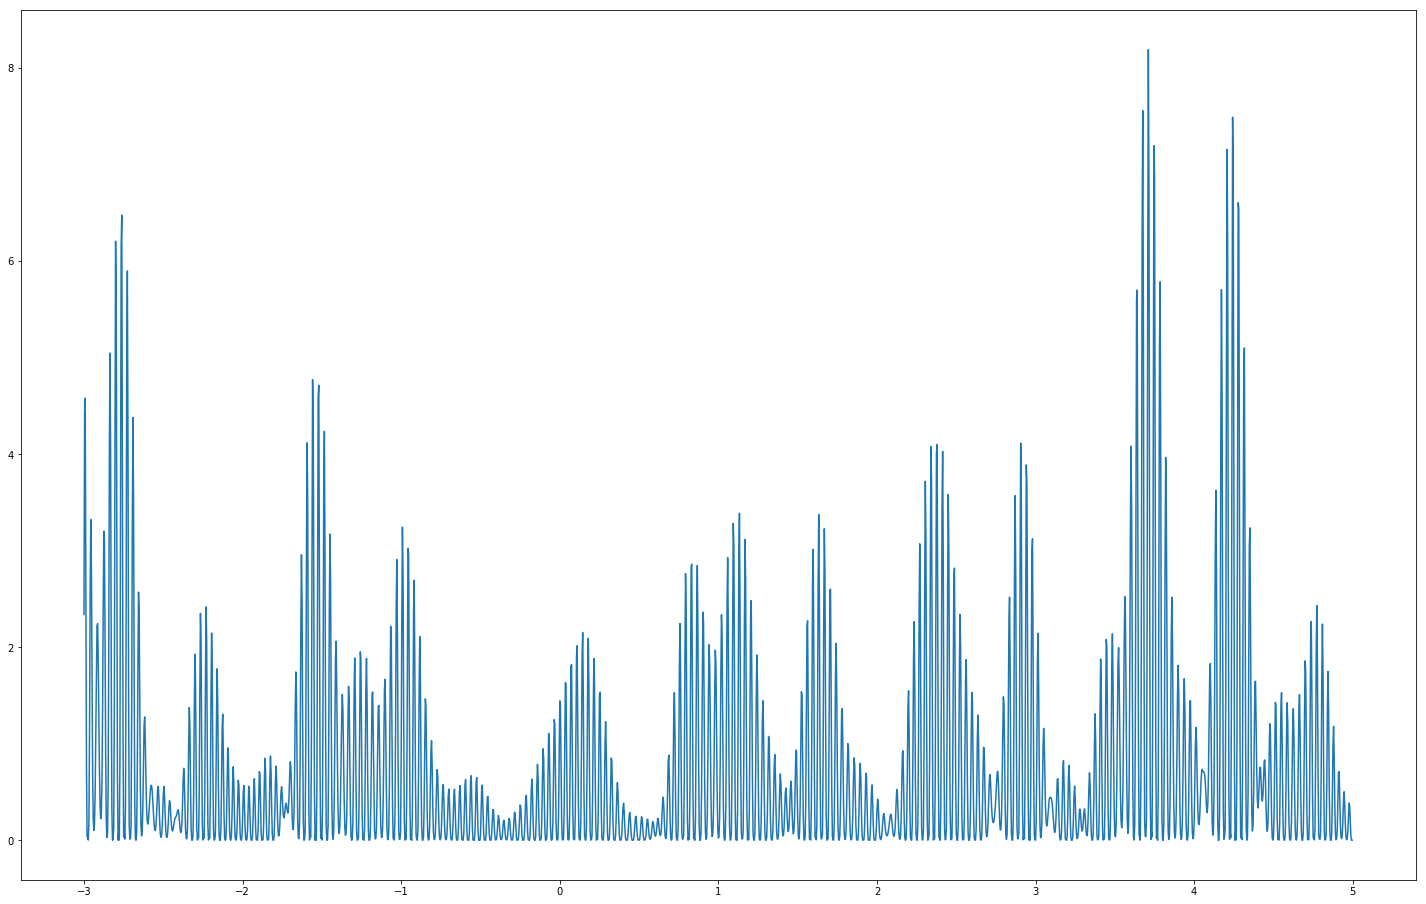

In [265]:
plt.rcParams["figure.figsize"] = [25,16]
plt.plot(np.arange(-3.0, 5.0, 1/256.0), ((epoch_beta[10][0]-z)**2))
plt.savefig("ers_ME 15 Day 90")

In [ ]:
###Subtract mean of the signal



In [111]:
def power(x):
    x=1.0*(x)
    return sum(x**2)/len(x)

In [132]:
###SubBand power ratio
#[alpha, beta, gamma, delta, theta]
spr=[]
for i in range(0, len(spr_channels)):
    powe=[]
    for j in range(0, len(sampletime1)):
        p=[]
        p.append(power(epoch_delta[i][j]))
        p.append(power(epoch_theta[i][j]))
        p.append(power(epoch_alpha[i][j]))
        p.append(power(epoch_beta[i][j]))
        p.append(power(epoch_gamma[i][j]))
        
        powe.append(p)
        
    spr.append(powe)
    
spr=spr/max(max(max(spr)))   

In [133]:
print len(spr), len(spr[0]), spr

21 5 [[[8.05450383e-02 9.09246505e-03 7.70292095e-03 5.10175557e-03
   3.42905060e-03]
  [1.84347671e-01 1.09223664e-02 8.65361076e-03 6.28409972e-03
   3.05840028e-03]
  [2.24527024e-01 1.91196340e-02 7.67466034e-03 5.35519985e-03
   2.60451525e-03]
  [3.08842614e-01 1.87655628e-02 6.98290168e-03 5.56431026e-03
   2.55881033e-03]
  [3.67482037e-01 1.86659912e-02 8.74789026e-03 5.41620874e-03
   3.47705429e-03]]

 [[6.38223203e-02 8.46847455e-03 6.97590005e-03 3.81242885e-03
   2.56720790e-03]
  [6.17841569e-02 1.18669788e-02 1.11030605e-02 4.10683186e-03
   2.36600498e-03]
  [6.35310224e-02 2.18733893e-02 8.80994553e-03 4.23127121e-03
   2.35837494e-03]
  [6.32305418e-02 2.38561714e-02 8.66080184e-03 4.82577350e-03
   2.14529145e-03]
  [2.07836281e-01 1.58288261e-02 9.21776851e-03 4.46098466e-03
   2.15451762e-03]]

 [[1.07095848e-01 1.09124873e-02 8.79204346e-03 4.15282152e-03
   2.75993799e-03]
  [1.66180618e-01 1.04333300e-02 7.53785070e-03 5.57003512e-03
   3.03402955e-03]
  [2.50

<BarContainer object of 5 artists>

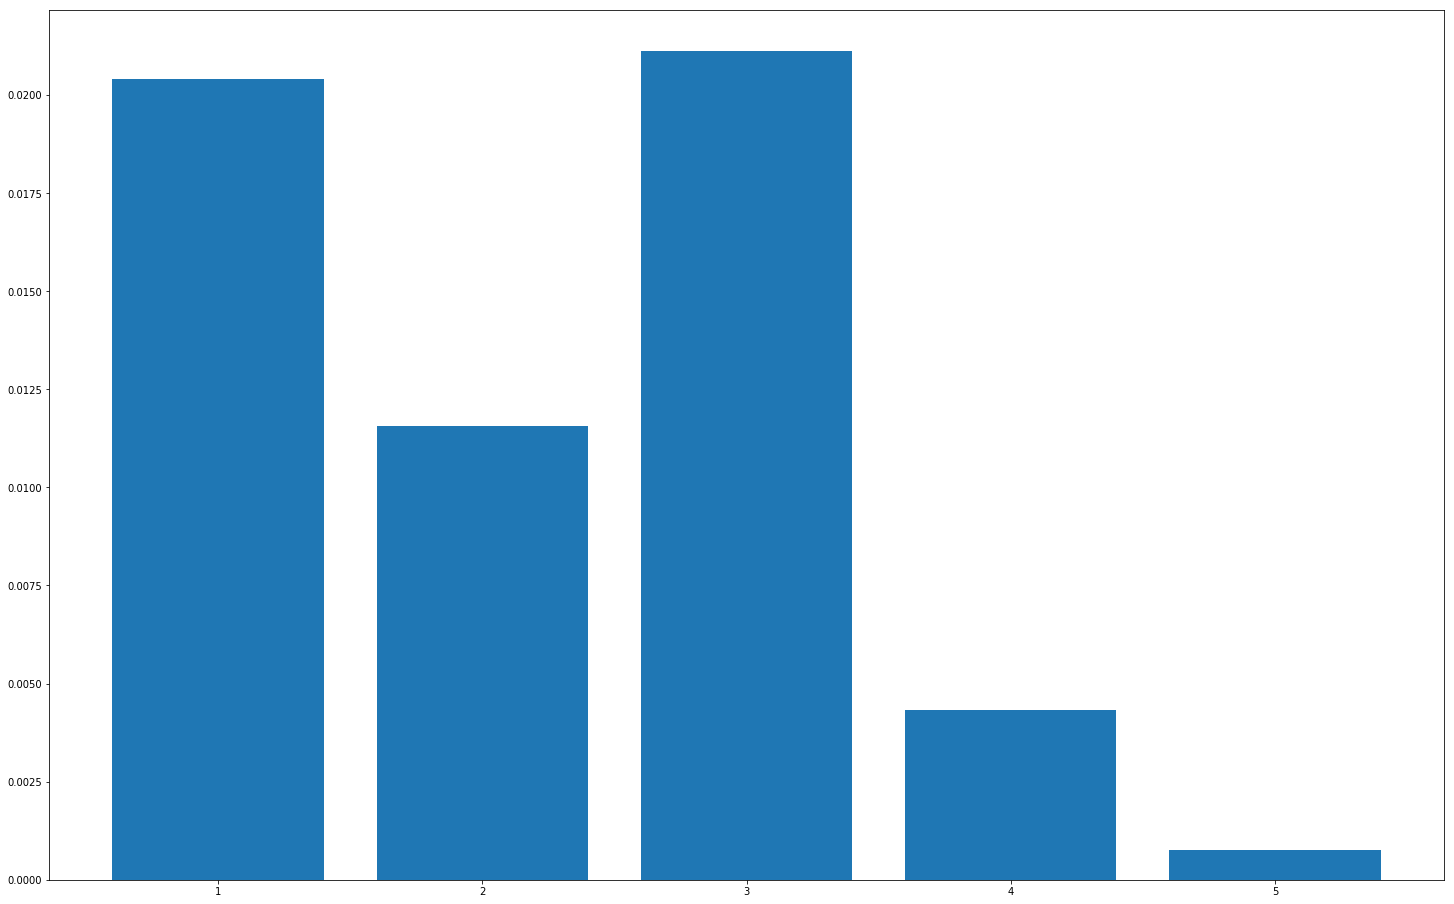

In [139]:
plt.bar([1,2,3,4,5], spr[16][0])

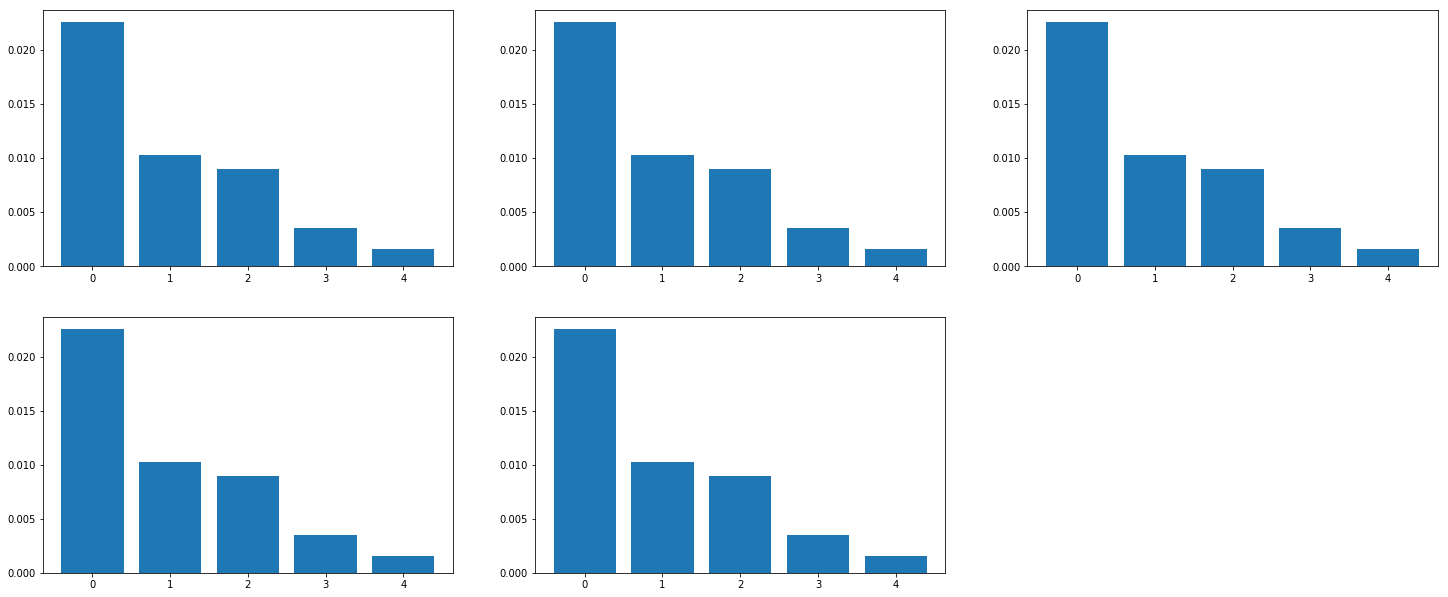

In [146]:
fig=plt.figure()####day wise comparision of the power ratio of pre and post exercise
for i in range(1, len(spr[0][0])+1):
    plot=fig.add_subplot(3,3,i)
    plt.bar(np.arange(len(spr[0][0])), spr[12][0])
    
plt.show()

In [ ]:
#power of alpha beta vs time plot